### Retrieve SDFs from directory (downloaded from Fragalysis)

In [1]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames

### Convert SDFs to rdkit mol objects

https://www.rdkit.org/docs/GettingStartedInPython.html

In [2]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


### Extract pharmacophores and their types and coordinates
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [3]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [4]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


Below functions similar but slightly different:
- one gets all coordinates for all mols, to collect coordinates for fragment cloud
- the second gets coordinates for a single mol which is more useful when dealing with the query molecules

In [5]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    donor_idxs = []

    for i, mol in enumerate(mols):
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')
        donor_idx += z
        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


In [6]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords

### Setting up fragment point cloud

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

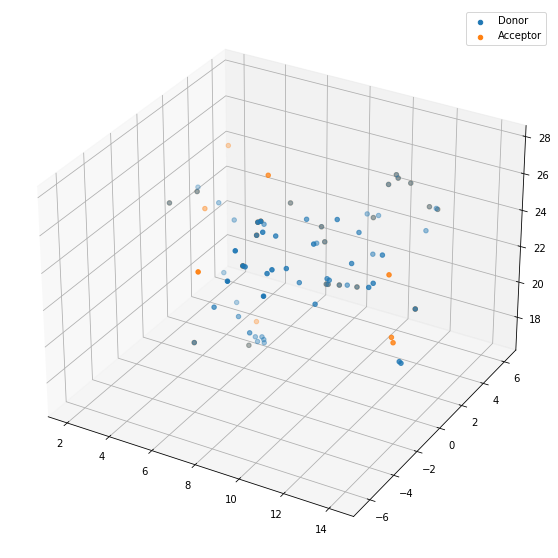

67
31


In [8]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)

# NOTE ~20 fragments, number of ph4s will obvs be different
# like 67 donors, 31 acceptors
print(len(frag_donor_coords)) 
print(len(frag_acceptor_coords))


### Setting up query molecules

*unfinished*

In [9]:
# run same functions for query mols - get mol from sdf
query_sdfs, query_filenames = get_sdfs('Mpro_query') 
query_mols = sdf_to_mol(query_sdfs)

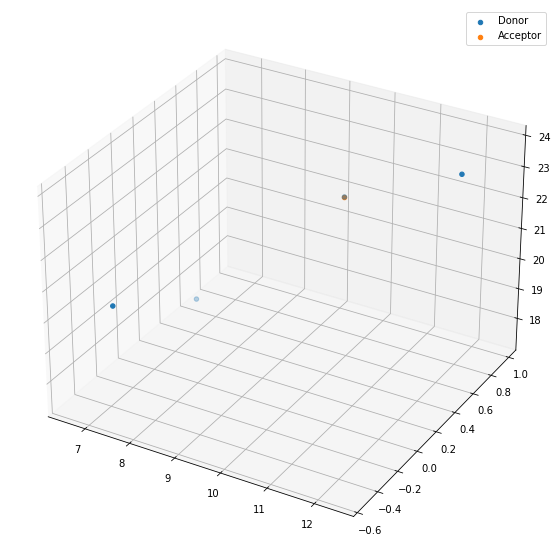

In [10]:
print(query_mols[0])
# get ph4 coords for mol
query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(query_mols[0])

# plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

labels = ['Donor', 'Acceptor', 'Aromatic']
for coords, label in zip([query_donor_coords, query_acceptor_coords, query_aromatic_coords], labels):
    if coords is not None:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

plt.legend()
plt.show()

# NOTE look at how to plot from list of dicts


# Brute force draft
https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/
trying to use my kabsch functions to align query to fragment cloud:
- for number of points in query cloud, get that number of points in fragment cloud in each combination possible
- limit by distance, ph4 type first to reduce computation needed
- then align query to each possible combination
- get best alignment 
generating combinations of points to align against

need to have:
- all different combinations of fragment ph4 points
- each different permutation of alignment of the query points to each different point in the subset (in each combination)

limit by:
- distances between points
- type of ph4
### Brute force

https://laempy.github.io/pyoints/tutorials/icp.html icp tutorial

https://gist.github.com/bougui505/e392a371f5bab095a3673ea6f4976cc8 pytorch kabsch

https://gist.github.com/jlmelville/9b4e5d076e719a7541881e8cbf58a895 R implementation kabsch


*brute force*
- need to do kabsch but limit distance and limit combinations of points
- generate combinations of points 
- filter down to points in fragment cloud that fit restrictions
- align query molecule to filtered fragment points/'allowed' ph4s 

In [11]:
import kabsch_functions_new as kabsch
import numpy as np
import scipy
import pandas as pd
import itertools

### Clustering

*unfinished*
- hierarchical clustering; use agglomerative clustering (sklearn)
- aim to reduce number of points in fragment point cloud if high density in particular areas
- 20 fragments with 98 points reduced to 36 clusters; if cluster also by ph4 type get 33 donor clusters and 18 acceptor clusters (no aromatic points)


https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/ - stuff on distance b/t clusters

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [13]:
def cluster(data, distance_threshold):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=distance_threshold) # 0.5 - 1 
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("Number of clusters found: {}".format(len(set(model.labels_))))
    labels = model.labels_
    print('Cluster for each point: ', model.labels_)

    return labels

Find centroids of clusters: 

In [14]:
# function to get centroid of cluster of points:
# have put coords into dataframes because find it easier to access x/y/z coords rather than slicing arrays
# can use grouping in dataframes to more easily find centroids of clustered points

def get_centroids(df):

    x_means = df.groupby(['cluster_label'])['x'].mean()
    y_means = df.groupby(['cluster_label'])['y'].mean() 
    z_means = df.groupby(['cluster_label'])['z'].mean()

    cluster_centroids = []
    for x, y, z in zip(x_means, y_means, z_means):
        centroid_coords = [x, y, z]
        cluster_centroids.append(centroid_coords)

    return cluster_centroids

### 11/5/22 brute force again, changed approach a bit - now using centroids, need to add permutations

- get points knowing ph4 type
- cluster the ph4 types separately
- get centroids for donor and acceptor clusters
- use centroids as new set of pocket points
- cluster centroids by distance (create subpockets)
- within each subpocket, get permutations of points restricted by ph4 types in query molecule
- collect all these combinations
- run kabsch on the possible permutations
- return best alignment (lowest rmsd)

In [23]:
# set up points
# query molecule
query_donors, query_acceptors, query_aromatic = get_coords_query(query_mols[0])
print(len(query_donors))
print(len(query_acceptors))
query_points = np.concatenate([query_donors, query_acceptors]) # just ignore aromatic points for now as we know there are none

# fragment points
frag_donor_coords
frag_acceptor_coords



4
1


array([[ 3.015,  1.422, 24.221],
       [ 7.423, -5.898, 25.439],
       [ 9.225,  1.32 , 21.213],
       [10.171,  4.696, 25.145],
       [ 9.435,  4.822, 23.01 ],
       [ 8.009, -2.377, 25.574],
       [ 7.503, -0.545, 27.591],
       [ 9.293, -4.285, 27.794],
       [ 5.753,  1.499, 17.784],
       [ 5.835, -3.666, 19.745],
       [ 9.21 , -5.539, 26.16 ],
       [ 8.777, -3.612, 27.202],
       [13.619, -1.569, 21.576],
       [ 8.537,  2.282, 22.783],
       [10.38 ,  1.646, 21.278],
       [ 8.32 ,  2.397, 23.48 ],
       [ 3.616,  1.022, 23.69 ],
       [13.261, -1.181, 24.573],
       [14.078, -0.459, 22.607],
       [11.317,  6.192, 23.477],
       [10.152,  5.422, 25.281],
       [13.831, -1.837, 21.524],
       [10.507,  6.044, 24.601],
       [10.367,  5.164, 25.305],
       [11.733,  6.115, 23.51 ],
       [ 2.874,  4.24 , 25.229],
       [ 2.191,  0.57 , 23.786],
       [ 9.129,  1.345, 21.176],
       [ 6.39 ,  3.265, 23.68 ],
       [ 5.819,  0.738, 16.905],
       [ 9

In [24]:
# cluster donor coords and add with labels to df
labels = cluster(frag_donor_coords, distance_threshold=1)
donor_df = pd.DataFrame([frag_donor_coords[:,0], frag_donor_coords[:,1], frag_donor_coords[:,2], labels])
donor_df = donor_df.transpose()
donor_df.columns = ['x', 'y', 'z', 'cluster_label']

# cluster acceptor coords and add with labels to df
labels = cluster(frag_acceptor_coords, distance_threshold=1)
acceptor_df = pd.DataFrame([frag_acceptor_coords[:,0], frag_acceptor_coords[:,1], frag_acceptor_coords[:,2], labels])
acceptor_df = acceptor_df.transpose()
acceptor_df.columns = ['x', 'y', 'z', 'cluster_label']



Number of clusters found: 46
Cluster for each point:  [45  3 25 38  5 31  6 24 10 36  8 14  7 30 28  2 39  9 23 34 44 27  3 43
 26 33  1 13 35  2  4  0  5  6 37 11  0  9 32  7 17  8 14 41 18 40 15 42
  3  7 14  8 16  3 22 29  1 30  4  3 12 10  0 19 21 20  5]
Number of clusters found: 23
Cluster for each point:  [ 1 16 21 10 13 12 15 22 20 11 19 14  2  4  0  4  1  5 17  3 10  2  9 10
  3 18  8 21  6  7  0]


In [25]:
# gives arrays of centroid coordinates for each cluster
donor_centroids = np.array(get_centroids(donor_df))
donor_centroid_df = pd.DataFrame([donor_centroids[:,0], donor_centroids[:,1], donor_centroids[:,2]]) # no cluster labels
donor_centroid_df = donor_centroid_df.transpose()
donor_centroid_df.columns = ['x', 'y', 'z']

acceptor_centroids = np.array(get_centroids(acceptor_df))
acceptor_centroid_df = pd.DataFrame([acceptor_centroids[:,0], acceptor_centroids[:,1], acceptor_centroids[:,2]]) # no cluster labels
acceptor_centroid_df = acceptor_centroid_df.transpose()
acceptor_centroid_df.columns = ['x', 'y', 'z']

# collect all points together as new pocket points
# create df with centroid points and labels for which ph4 type, so can separate back out different ph4 types later
# NOTE need to make this into function/more flexible
for row in donor_centroid_df.iterrows():
    donor_centroid_df['ph4_label'] = 'Donor'
for row in acceptor_centroid_df.iterrows():
    acceptor_centroid_df['ph4_label'] = 'Acceptor'

pocket_df = pd.concat([donor_centroid_df, acceptor_centroid_df]) 
print(pocket_df)

            x       y          z ph4_label
0    8.306667  2.3820  22.902667     Donor
1    8.898000 -5.2885  26.304000     Donor
2    8.283000 -2.0990  25.490000     Donor
3    6.549800  0.4448  17.680000     Donor
4   10.118000 -0.3380  22.752500     Donor
..        ...     ...        ...       ...
18   2.874000  4.2400  25.229000  Acceptor
19   9.210000 -5.5390  26.160000  Acceptor
20   5.753000  1.4990  17.784000  Acceptor
21   9.177000  1.3325  21.194500  Acceptor
22   9.293000 -4.2850  27.794000  Acceptor

[69 rows x 4 columns]


cluster pocket_points by distance:

- in this case for this one query molecule we only get one cluster because max distance is large, so number of permutations very high; have tested other molecules giving ~5 clusters which reduces number of permutations a lot

In [26]:
# cluster pocket_points by distance

# get max distance for pairwise points of query molecule
pdist_q = scipy.spatial.distance.pdist(query_points, metric='euclidean')
max_query_dist = np.max(pdist_q)
print(max_query_dist)

# get possible subpockets of fragment cloud by clustering, use query max dist as threshold

pocket_points = []
for x,y,z in zip(pocket_df['x'], pocket_df['y'], pocket_df['z']):
        # NOTE bug here, separation in donor/acceptor not adding up properly
        pocket_point = [x,y,z]
        pocket_points.append(pocket_point)
pocket_points = np.array(pocket_points)

cluster_labels = cluster(pocket_points, distance_threshold=max_query_dist) # order not lost ?? so use just points in clustering, then append list of labels to existing df with ph4 labels
pocket_df['cluster_label'] = pd.Series(cluster_labels) # NOTE should check this works ie stays in order/labels not wrong
print(pocket_df)


8.68015863910332
Number of clusters found: 1
Cluster for each point:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
            x       y          z ph4_label  cluster_label
0    8.306667  2.3820  22.902667     Donor              0
1    8.898000 -5.2885  26.304000     Donor              0
2    8.283000 -2.0990  25.490000     Donor              0
3    6.549800  0.4448  17.680000     Donor              0
4   10.118000 -0.3380  22.752500     Donor              0
..        ...     ...        ...       ...            ...
18   2.874000  4.2400  25.229000  Acceptor              0
19   9.210000 -5.5390  26.160000  Acceptor              0
20   5.753000  1.4990  17.784000  Acceptor              0
21   9.177000  1.3325  21.194500  Acceptor              0
22   9.293000 -4.2850  27.794000  Acceptor              0

[69 rows x 5 columns]


In [27]:

# sort back into ph4 types within main clusters (subpockets)
ph4_combinations = [] # set up empty list to store fragment point combinations
ph4_permutations = []

cluster_groups =  pocket_df.groupby('cluster_label')
for name, group in cluster_groups:
    # need to separate back into ph4 types
    # group within clusters by ph4 type
    ph4_types = group.groupby('ph4_label')
    # get arrays of point coords from each ph4 type
    donors = []
    acceptors = []
    for name, group in ph4_types:
        print(name, len(group))  # checked - gives totals of acceptors/donors expected
        for x,y,z in zip(group['x'], group['y'], group['z']):
            coords = [x,y,z]
            if name == 'Donor':
                donors.append(coords)
            elif name == 'Acceptor':
                acceptors.append(coords)

    # get possible combinations/permutations within subpocket, restricted by type/numbers of different ph4s in query molecule
    # e.g. first query mol has 4 donors, 1 acceptor, so from frag donor points choose 4, from acceptor points choose 1 (and then get permutations for different correspondences)
    for permutation in list(itertools.product(itertools.permutations(acceptors, len(query_acceptors)), itertools.permutations(donors, len(query_donors)))):
        ph4_permutations.append(permutation) 

print('PERMUTATIONS:', len(ph4_permutations)) # check number expected; 


Acceptor 23
Donor 46
PERMUTATIONS: 90078120


In [28]:
# create df to hold results
results_df = pd.DataFrame()
rmsd_vals = []
permutations = [] 
qm_aligned_all = []

for permutation in ph4_permutations[0:100000]: # NOTE change from subset of permutations when finalising code

    # reformat coords for kabsch (N, 3)
    permutation = np.concatenate(permutation)

    qm_means = query_points.mean(0)
    rm_means = permutation.mean(0)
    qm_trans = query_points - qm_means
    rm_trans = permutation - rm_means

    trans_vector =  rm_means # add to revert_translation

    #For more speed use scipy.spatial.transform.Rotation.align_vectors. You still need to deal with translation
    h = kabsch.compute_covariance_matrix(rm_trans, qm_trans)
    r = kabsch.compute_optimal_rotation_matrix(h)
    qm_rotated = kabsch.apply_rotation(qm_trans, r)

    # qm_reverted, frm_reverted = revert_translation(qm_rotated, frm_trans, qm_means, frm_means)
    qm_aligned =  qm_rotated + trans_vector
    rmsd_val = kabsch.rmsd(qm_aligned, rm_trans+ trans_vector)

    # collect results
    rmsd_vals.append(rmsd_val)
    permutations.append(permutation)
    qm_aligned_all.append(qm_aligned)

results_df['RMSD'] = pd.Series(rmsd_vals)
results_df['Fragment'] = pd.Series(permutations)
results_df['Query'] = pd.Series(qm_aligned_all)



Get best result/s:


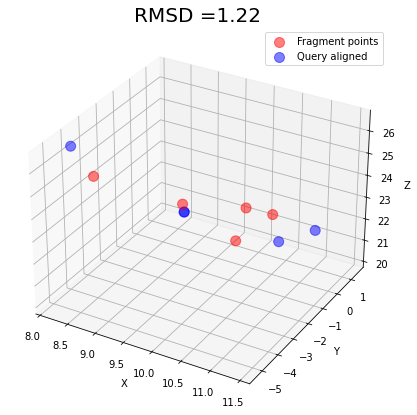

In [29]:
# get row of df with lowest RMSD to get fragment and query points
best_results = results_df.loc[results_df['RMSD'] == np.min(results_df['RMSD'])]
best_results = pd.DataFrame(best_results, columns=['RMSD', 'Fragment', 'Query'])

for result in best_results.itertuples(index=False):

    # plot best result/s (sometimes multiple with same RMSD)
    ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
    # plot matrices for comparison 
    ax.scatter3D(result[1][:,0], result[1][:,1], result[1][:,2], label='Fragment points', color='r', s=100, alpha=0.5)
    ax.scatter3D(result[2][:,0], result[2][:,1], result[2][:,2], label='Query aligned', color='b', s=100, alpha=0.5)
    # set plot titles and labels
    ax.legend(loc='upper right')
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    plt.title(str('RMSD =' + str("{:.2f}".format(float(result[0])))), fontsize=20)



Plot distribution of RMSD values:


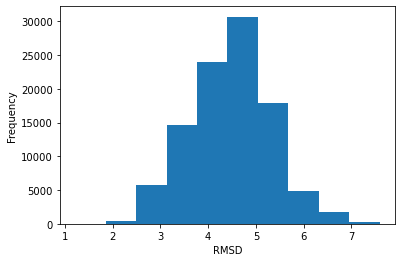

In [30]:
plt.figure()
plt.hist(rmsd_vals)
plt.ylabel('Frequency')
plt.xlabel('RMSD')
plt.show()


### 12/5/22 to do

- set up as functions, clean up code/notebook 
- set up script so can loop over query molecules (and conformers)

next week:
- testing
- parallelisation